# One-Dimensional Flow and Comparison to Analytical Solution

Use DIS2D (overland flow) and DISV1D (Channel Flow) to simulate one-dimensional flow and compare the results to the analytical solution.

In [179]:
import pathlib as pl
import matplotlib.pyplot as plt
import numpy as np
import flopy

In [180]:
ws = pl.Path('./mf6_sim')
name = 'oned'

In [181]:
def h_analytical(x, x0, x1, h0, h1):
    rho = (x - x0) / (x1 - x0)
    h = ((1 - rho) * h0 ** (13./3.) + rho * h1 ** (13./3.)) ** (3./13.)
    return h

Text(0.5, 1.0, 'Analytical Solution')

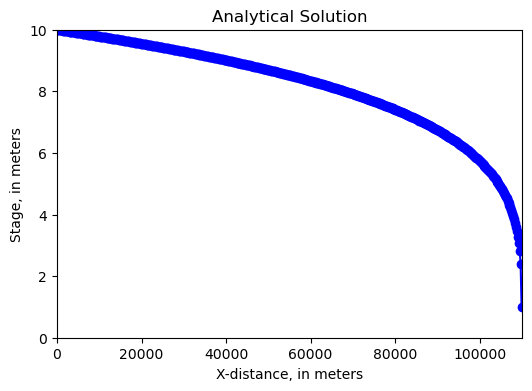

In [182]:
# make modflow model
exe_name = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
sim_ws = ws

Lx = 110000
ncol = 501
dx = Lx / ncol

h0 = 10.0
h1 = 1.0
x0 = 0.5 * dx
x1 = Lx - 0.5 * dx
x = np.linspace(x0, x1, ncol)
h_analytical_solution = h_analytical(x, x0, x1, h0, h1)

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(x, h_analytical_solution, 'bo-')
ax.set_xlim(0, Lx)
ax.set_ylim(0, h0)
ax.set_xlabel("X-distance, in meters")
ax.set_ylabel("Stage, in meters")
ax.set_title("Analytical Solution")

In [183]:
nper = 1
perlen = nper * [1036800.0]
nstp = nper * [1]
tsmult = nper * [1]

tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

name = "swf"

# build MODFLOW 6 files
sim = flopy.mf6.MFSimulation(
    sim_name=f"{name}_sim",
    version="mf6",
    exe_name=exe_name,
    sim_ws=sim_ws,
)

# create tdis package
ats_filerecord = None
tdis = flopy.mf6.ModflowTdis(
    sim,
    ats_filerecord=ats_filerecord,
    time_units="SECONDS",
    nper=nper,
    perioddata=tdis_rc,
)

def add_model(sim, modelname, dis_type):

    # surface water model
    swf = flopy.mf6.ModflowSwf(sim, modelname=modelname, save_flows=True)

    nouter, ninner = 200, 30
    hclose, rclose, relax = 1e-8, 1e-8, 0.97
    imsswf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="DBD",
        under_relaxation_theta=0.9,
        under_relaxation_kappa=0.0001,
        under_relaxation_gamma=0.0,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        preconditioner_levels=7,
        # backtracking_number=5,
        # backtracking_tolerance=1.0,
        # backtracking_reduction_factor=0.3,
        # backtracking_residual_limit=100.0,
        filename=f"{modelname}.ims",
    )
    sim.register_ims_package(imsswf, [swf.name])

    land_surface = 0.
    if dis_type == "dis2d":
        dis2d = flopy.mf6.ModflowSwfdis2D(
            swf,
            nrow=1,
            ncol=ncol,
            delr=dx,
            delc=1.,
            botm=land_surface,
            xorigin=0.,
        )
    elif dis_type == "disv1d":
        nodes = ncol
        nvert = nodes + 1
        vertices = [[j, j * dx, 0.0] for j in range(nodes + 1)]
        cell2d = [[j, 0.5, 2, j, j + 1] for j in range(nodes)]
        disv1d = flopy.mf6.ModflowSwfdisv1D(
            swf, 
            nodes=nodes, 
            nvert=nvert,
            length=dx,
            width=1.0,
            bottom=land_surface,
            idomain=1, 
            vertices=vertices, 
            cell2d=cell2d,
        )
    else:
        raise Exception(f"unknown dis type: {dis_type}")

    roughness = 1.0
    dfw = flopy.mf6.ModflowSwfdfw(
        swf,
        dev_swr_conductance=False,
        central_in_space=False,
        print_flows=False,
        save_flows=True,
        save_velocity=True,
        manningsn=roughness,
        idcxs=None,
    )

    ic = flopy.mf6.ModflowSwfic(
        swf,
        strt=h0,
    )

    # output control
    oc = flopy.mf6.ModflowSwfoc(
        swf,
        budget_filerecord=f"{modelname}.bud",
        stage_filerecord=f"{modelname}.stage",
        saverecord=[
            ("STAGE", "ALL"),
            ("BUDGET", "ALL"),
        ],
        printrecord=[
            ("BUDGET", "ALL"),
        ],
    )

    # Assign constant heads in first and last reach.
    if dis_type == "dis2d":
        spd = [(0, 0, h0), (0, ncol - 1, h1)]
    elif dis_type == "disv1d":
        spd = [(0, h0), (nodes - 1, h1)]
    chd = flopy.mf6.ModflowSwfchd(
        swf,
        maxbound=len(spd),
        print_input=True,
        print_flows=True,
        stress_period_data=spd,
    )

swfname = "overland"
add_model(sim, swfname, dis_type="dis2d")

swfname = "channel"
add_model(sim, swfname, dis_type="disv1d")

# write the model files
sim.write_simulation()

# run the model
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing model overland...
    writing model name file...
    writing package dis2d...
    writing package dfw...
    writing package ic...
    writing package oc...
    writing package chd_0...
  writing model channel...
    writing model name file...
    writing package disv1d...
    writing package dfw...
    writing package ic...
    writing package oc...
    writing package chd_0...
FloPy is using the following executable to run the model: ../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 02/13/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Apr 29 2024 12:27:05 with GCC version 13.2.0

This software is preliminary or provisional and is 

(True, [])

(-1.0, 1.0)

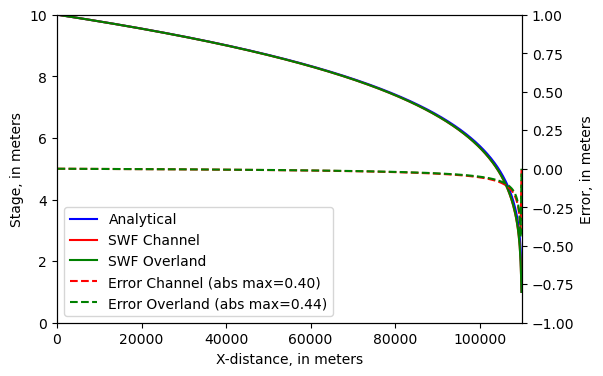

In [189]:
fpth = sim_ws / f"channel.stage"
stage_obj = flopy.utils.HeadFile(fpth, text="STAGE")
stage_channel = stage_obj.get_data().flatten()

fpth = sim_ws / f"overland.stage"
stage_obj = flopy.utils.HeadFile(fpth, text="STAGE")
stage_overland = stage_obj.get_data().flatten()

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
lns1 = ax.plot(x, h_analytical_solution, 'b-', label="Analytical")
lns2 = ax.plot(x, stage_channel, marker=None, mfc="none", color="red", ls="-", label="SWF Channel")
lns3 = ax.plot(x, stage_overland, marker=None, mfc="none", color="green", ls="-", label="SWF Overland")
ax.set_xlim(0, Lx)
ax.set_ylim(0, h0)
ax.set_xlabel("X-distance, in meters")
ax.set_ylabel("Stage, in meters")

ax = ax.twinx()
diff = stage_channel - h_analytical_solution
lns4 = ax.plot(x, diff, 'r--', label=f"Error Channel (abs max={np.abs(diff).max():.2f})")
diff = stage_overland - h_analytical_solution
lns5 = ax.plot(x, diff, 'g--', label=f"Error Overland (abs max={np.abs(diff).max():.2f})")

lns = lns1 + lns2 + lns3 + lns4 + lns5
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="lower left")

ax.set_ylabel("Error, in meters")
ax.set_ylim(-1, 1)

# Specified Inflow Version

In [223]:
def h_analytical_specified_inflow(Q0, rough, x, x1, h1):
    h = (Q0 ** 2 * rough ** 2 * (x1 - x) + h1 ** (13./ 3.)) ** (3./ 13.)
    return h

Text(0.5, 1.0, 'Analytical Solution')

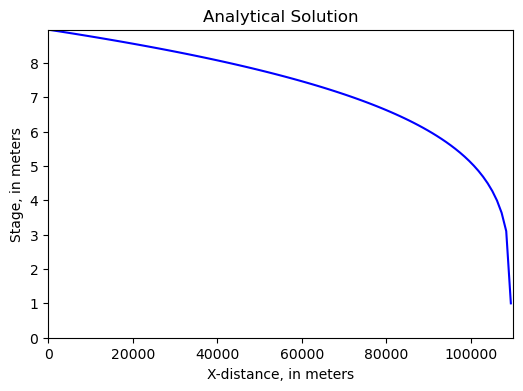

In [248]:
Lx = 110000
ncol = 101
dx = Lx / ncol

Q0 = 10.0 # m^2/s
rough = 0.035
h1 = 1.0
x1 = Lx - 0.5 * dx
x = np.linspace(x0, x1, ncol)
h_analytical2 = h_analytical_specified_inflow(Q0, rough, x, x1, h1)

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(x, h_analytical2, 'b-')
ax.set_xlim(0, Lx)
ax.set_ylim(0, h_analytical2.max())
ax.set_xlabel("X-distance, in meters")
ax.set_ylabel("Stage, in meters")
ax.set_title("Analytical Solution")

In [249]:
nper = 1
perlen = nper * [1036800.0]
nstp = nper * [1]
tsmult = nper * [1]

tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

name = "swf"

# build MODFLOW 6 files
sim = flopy.mf6.MFSimulation(
    sim_name=f"{name}_sim",
    version="mf6",
    exe_name=exe_name,
    sim_ws=sim_ws,
)

# create tdis package
ats_filerecord = None
tdis = flopy.mf6.ModflowTdis(
    sim,
    ats_filerecord=ats_filerecord,
    time_units="SECONDS",
    nper=nper,
    perioddata=tdis_rc,
)

def add_model(sim, modelname, dis_type):

    # surface water model
    swf = flopy.mf6.ModflowSwf(sim, modelname=modelname, save_flows=True)

    nouter, ninner = 200, 30
    hclose, rclose, relax = 1e-8, 1e-8, 0.97
    imsswf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="DBD",
        under_relaxation_theta=0.9,
        under_relaxation_kappa=0.0001,
        under_relaxation_gamma=0.0,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        preconditioner_levels=7,
        # backtracking_number=5,
        # backtracking_tolerance=1.0,
        # backtracking_reduction_factor=0.3,
        # backtracking_residual_limit=100.0,
        filename=f"{modelname}.ims",
    )
    sim.register_ims_package(imsswf, [swf.name])

    land_surface = 0.
    if dis_type == "dis2d":
        dis2d = flopy.mf6.ModflowSwfdis2D(
            swf,
            nrow=1,
            ncol=ncol,
            delr=dx,
            delc=1.,
            botm=land_surface,
            xorigin=0.,
        )
    elif dis_type == "disv1d":
        nodes = ncol
        nvert = nodes + 1
        vertices = [[j, j * dx, 0.0] for j in range(nodes + 1)]
        cell2d = [[j, 0.5, 2, j, j + 1] for j in range(nodes)]
        disv1d = flopy.mf6.ModflowSwfdisv1D(
            swf, 
            nodes=nodes, 
            nvert=nvert,
            length=dx,
            width=1.0,
            bottom=land_surface,
            idomain=1, 
            vertices=vertices, 
            cell2d=cell2d,
        )
    else:
        raise Exception(f"unknown dis type: {dis_type}")

    dfw = flopy.mf6.ModflowSwfdfw(
        swf,
        dev_swr_conductance=False,
        central_in_space=False,
        print_flows=False,
        save_flows=True,
        save_velocity=True,
        manningsn=rough,
        idcxs=None,
    )

    ic = flopy.mf6.ModflowSwfic(
        swf,
        strt=h0,
    )

    # output control
    oc = flopy.mf6.ModflowSwfoc(
        swf,
        budget_filerecord=f"{modelname}.bud",
        stage_filerecord=f"{modelname}.stage",
        saverecord=[
            ("STAGE", "ALL"),
            ("BUDGET", "ALL"),
        ],
        printrecord=[
            ("BUDGET", "ALL"),
        ],
    )

    # Assign constant heads in last reach.
    if dis_type == "dis2d":
        spd = [(0, ncol - 1, h1)]
    elif dis_type == "disv1d":
        spd = [(nodes - 1, h1)]
    chd = flopy.mf6.ModflowSwfchd(
        swf,
        maxbound=len(spd),
        print_input=True,
        print_flows=True,
        stress_period_data=spd,
    )

    # Assign constant inflow in first reach.
    if dis_type == "dis2d":
        spd = [(0, 0, Q0)]
    elif dis_type == "disv1d":
        spd = [(0, Q0)]
    flw = flopy.mf6.ModflowSwfflw(
        swf,
        maxbound=len(spd),
        print_input=True,
        print_flows=True,
        stress_period_data=spd,
    )

swfname = "overland"
add_model(sim, swfname, dis_type="dis2d")

swfname = "channel"
add_model(sim, swfname, dis_type="disv1d")

# write the model files
sim.write_simulation()

# run the model
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing model overland...
    writing model name file...
    writing package dis2d...
    writing package dfw...
    writing package ic...
    writing package oc...
    writing package chd_0...
    writing package flw_0...
  writing model channel...
    writing model name file...
    writing package disv1d...
    writing package dfw...
    writing package ic...
    writing package oc...
    writing package chd_0...
    writing package flw_0...
FloPy is using the following executable to run the model: ../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 02/13/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Apr 29 2024 12:27:05 with GCC version 1

(True, [])

(-1.0, 1.0)

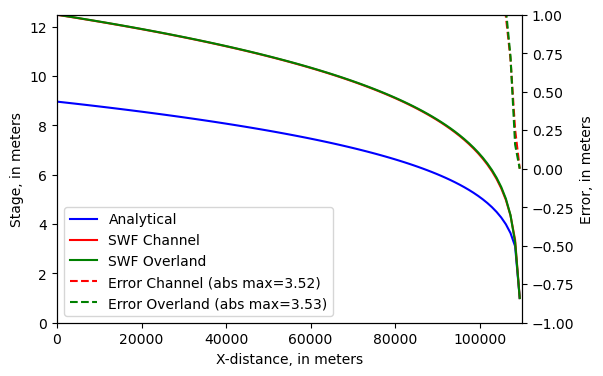

In [250]:
fpth = sim_ws / f"channel.stage"
stage_obj = flopy.utils.HeadFile(fpth, text="STAGE")
stage_channel = stage_obj.get_data().flatten()

fpth = sim_ws / f"overland.stage"
stage_obj = flopy.utils.HeadFile(fpth, text="STAGE")
stage_overland = stage_obj.get_data().flatten()

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
lns1 = ax.plot(x, h_analytical2, 'b-', label="Analytical")
lns2 = ax.plot(x, stage_channel, marker=None, mfc="none", color="red", ls="-", label="SWF Channel")
lns3 = ax.plot(x, stage_overland, marker=None, mfc="none", color="green", ls="-", label="SWF Overland")
ax.set_xlim(0, Lx)
ax.set_ylim(0, max(h_analytical2.max(), stage_channel.max(), stage_overland.max()))
ax.set_xlabel("X-distance, in meters")
ax.set_ylabel("Stage, in meters")

ax = ax.twinx()
diff = stage_channel - h_analytical2
lns4 = ax.plot(x, diff, 'r--', label=f"Error Channel (abs max={np.abs(diff).max():.2f})")
diff = stage_overland - h_analytical2
lns5 = ax.plot(x, diff, 'g--', label=f"Error Overland (abs max={np.abs(diff).max():.2f})")

lns = lns1 + lns2 + lns3 + lns4 + lns5
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="lower left")

ax.set_ylabel("Error, in meters")
ax.set_ylim(-1, 1)